### 小売り顧客のクラスタリング

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
column_names = [
    "販売チャネル",
    "地域",
    "新鮮品",
    "乳製品",
    "食料品",
    "冷凍食品",
    "洗剤・紙製品",
    "惣菜",   
]

In [3]:
df = pd.read_csv('Wholesale customers data.csv', header=0, names=column_names)

In [4]:
df.head(10)

,販売チャネル,地域,新鮮品,乳製品,食料品,冷凍食品,洗剤・紙製品,惣菜
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


### データを小売りに絞る

In [5]:
df = df[df["販売チャネル"] == 2]

In [6]:
df.head(10)

,販売チャネル,地域,新鮮品,乳製品,食料品,冷凍食品,洗剤・紙製品,惣菜
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
9,2,3,6006,11093,18881,1159,7425,2098
10,2,3,3366,5403,12974,4400,5977,1744
11,2,3,13146,1124,4523,1420,549,497


In [7]:
# 販売チャネルは不要なので削除
df = df.drop("販売チャネル", axis=1)

In [8]:
pd.get_dummies(df)

,地域,新鮮品,乳製品,食料品,冷凍食品,洗剤・紙製品,惣菜
0,3,12669,9656,7561,214,2674,1338
1,3,7057,9810,9568,1762,3293,1776
2,3,6353,8808,7684,2405,3516,7844
4,3,22615,5410,7198,3915,1777,5185
5,3,9413,8259,5126,666,1795,1451
...,...,...,...,...,...,...,...
418,3,660,8494,18622,133,6740,776
421,3,17063,4847,9053,1031,3415,1784
423,3,17565,3686,4657,1059,1803,668
424,3,16980,2884,12232,874,3213,249


### データ確認

In [9]:
# データの形状確認
df.shape

(142, 7)

In [10]:
# 欠損値を確認
df.isnull().sum()

地域        0
新鮮品       0
乳製品       0
食料品       0
冷凍食品      0
洗剤・紙製品    0
惣菜        0
dtype: int64

In [11]:
df.describe()

,地域,新鮮品,乳製品,食料品,冷凍食品,洗剤・紙製品,惣菜
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
mean,2.612676,8904.323944,10716.500000,16322.852113,1652.612676,7269.507042,1753.436620
std,0.703069,8987.714750,9679.631351,12267.318094,1812.803662,6291.089697,1953.797047
min,1.000000,18.000000,928.000000,2743.000000,33.000000,332.000000,3.000000
25%,2.000000,2347.750000,5938.000000,9245.250000,534.250000,3683.500000,566.750000
50%,3.000000,5993.500000,7812.000000,12390.000000,1081.000000,5614.500000,1350.000000
75%,3.000000,12229.750000,12162.750000,20183.500000,2146.750000,8662.500000,2156.000000
max,3.000000,44466.000000,73498.000000,92780.000000,11559.000000,40827.000000,16523.000000


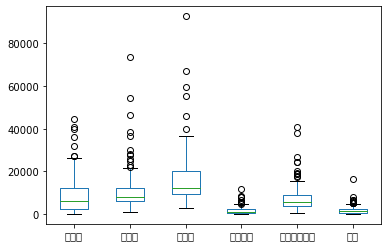

In [12]:
boxplot_df = df.drop(columns=["地域"])
boxplot_df.boxplot(grid=False)
plt.show()

### 3σ法により外れ値を処理

In [13]:
cleaned_df = boxplot_df.copy()
for column in boxplot_df.columns:
    # 平均と標準偏差を計算
    mean = cleaned_df[column].mean()
    std = cleaned_df[column].std()
    
    # 3σの範囲を計算
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    
    # 3σの範囲外のデータを除外
    cleaned_df = cleaned_df[(cleaned_df[column] >= lower_bound) & (cleaned_df[column] <= upper_bound)]

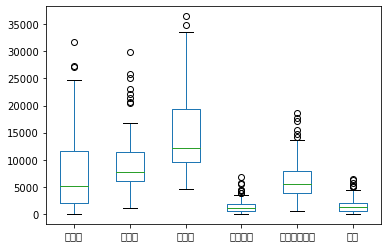

In [14]:
cleaned_df.boxplot(grid=False)
plt.show()

### エルボー法

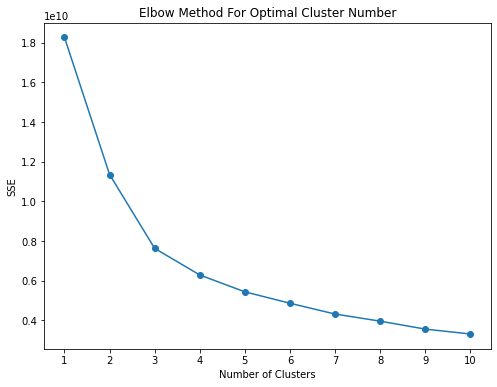

In [15]:
from sklearn.cluster import KMeans

# クラスタ数のリスト
cluster_range = range(1, 11)  # 1から10までのクラスタ数を試す

# 各クラスタ数でのSSEを保存するリスト
sse = []

# クラスタ数を変えながらKMeansクラスタリングを実行し、SSEを計算
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10,  random_state=0)
    kmeans.fit(cleaned_df)
    sse.append(kmeans.inertia_)  # inertia_属性にはSSEが保存されている

# エルボー法のプロットを作成
plt.figure(figsize=(8,6))
plt.plot(cluster_range, sse, marker='o')
plt.title('Elbow Method For Optimal Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.xticks(cluster_range)
plt.show()


### クラスタリング

In [16]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

In [17]:
cleaned_df['Cluster'] = kmeans.fit_predict(cleaned_df)

In [18]:
# PCAで2次元に削減
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(cleaned_df.drop('Cluster', axis=1))

### 結果の可視化

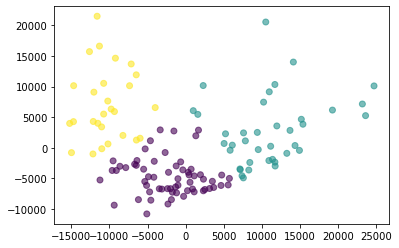

In [19]:
 plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cleaned_df['Cluster'], cmap='viridis', alpha=0.6)